# Notebook  10 - Parallel Computing

Questa lezione utilizza la libreria MPI (Message Passing Interface) per migliorare le performance del codice del Notebook 9, relativo al problema del commesso viaggiatore, attraverso la computazione parallela. Viene usato il modello SPMD ( <i> Single Program Multiple Data </i>), nel quale il codice eseguito è sempre lo stesso, ma ognuno dei processi portati avanti in parallelo utilizza dati diversi.

   - [  10.1 - Spiegazione del codice ](#ex-10.1) 

   - [  10.2 - Travelling Salesman Problem ](#ex-10.2) 
   

In [48]:
import matplotlib.pyplot as plt
import numpy as np

<a id="ex-10.1"></a>
## Esercizio 10.1 - Spiegazione del codice
Attraverso la libreria MPI, è possibile attuare l'esecuzione in parallelo del programma. Senza inoltrarsi troppo nel funzionamento della libreria, il senso è che il processo viene fatto svolgere in parallelo su più "nodi", ognuno dei quali opera su dati diversi in maniera completamente indipendente (in realtà questo non è necessariamente vero, come vedremo nel concetto di <i> migrazioni </i>). Si vuole ora spiegare brevemente qual'è stato il processo di integrazione del codice presente nel Notebook 9, tramite una breve spiegazione delle funzioni della libreria `mpi.h` introdotte.
- `Mpi.Init()` `Mpi.Finalize()` sono le funzioni che determinano l'inizio e la fine dell'ambiente MPI. Tutto il codice presente tra queste due funzioni verrà eseguito in parallelo.
- `MPI_Comm_size(MPI_COMM_WORLD, &size)` e `MPI_Comm_rank(MPI_COMM_WORLD, &rank)` sono le funzioni che determinano il numero e il label dei vari nodi che verranno utilizzati. `size` rappresenta il numero di nodi, mentre `rank` è un etichetta associata ad ogni nodo, che viene utilizzata nelle comunicazioni tra i vari nodi. In questo Notebook si è operato con $8$ nodi.
- La variabile `MPI_COMM_WORLD`, detta <i> comunicatore </i>, rappresenta il gruppo di processi paralleli ed è la responsabile della comunicazione.

Una volta settato l'ambiente MPI, si possono introdurre i concetti di <i> comunicazione </i> tra i blocchi. La comunicazione tra i nodi non è necessaria: si può lasciare che tutti i nodi operino indipendentemente per poi raccogliere i risultati migliori. D'altra parte si può anche, tramite le funzioni che verranno ora elencate, permettere ai nodi di scambiarsi materiale, influenzandosi quindi vicendevolmente nella ricerca di soluzioni.

- `MPI_BCast()`: Permette di inviare materiale da un nodo a tutti gli altri.
- `MPI_Isend()`: Permette di inviare materiale da un nodo ad un altro.
- `MPI_Recv()`: Permette di ricevere materiale da un altro nodo.

Le funzioni qua introdotte permettono di introdurre il concetto di <i> migrazioni </i>. Per rimanere nel paragone dello scorso Notebook, ogni nodo prenderà il nome di <i> continente </i>, e si dirà migrazione lo spostamento di una parte di popolazione da un continente ad un altro. Il procedimento è stato il seguente:

- Ogni numero di generazioni fisso $N_{migr}$ viene attuata una migrazione. Il nodo principale (quello con rank = 0) decide gli accoppiamenti in modo casuale e attraverso `MPI_BCast()` comunica a tutti i nodi le informazioni sugli accoppiamenti. 
- A questo punto ogni nodo è appaiato ad un altro, e attraverso le due funzioni `MPI_Isend()` e `MPI_Recv()` i due nodi si scambiano un numero impostabile di migliori individui e poi riprendono con l'evoluzione secondo l'algoritmo genetico. 

La MPI ha permesso non solo di diminuire notevolmente il tempo di esecuzione, ma anche di introdurre il concettualmente nuovo processo di migrazione. Si forniscono ora i risultati nei casi studiati. In particolare, si è voluto applicare il problema del commesso viaggiatore alla mappa delle $50$ capitali degli Stati Uniti d'America, fornite attraverso le loro coordinate, opportunamente proiettate su un piano bidimensionale.

<a id="ex-10.2"></a>
## Esercizio 10.2 - Travelling Salesman Problem

### Continenti Non Comunicanti
Il problema è stato ri-affrontato con due procedimenti diversi. Nel primo caso (<b> Continenti non Comunicanti </b>) non sono state permesse le migrazioni, e quindi ogni nodo è stato obbligato a lavorare singolarmente. I parametri utilizzati sono stati $G = 500$ generazioni, ognuna composta da $M=2000$ cromosomi. Si forniscono i risultati per ogni nodo. Per impedire le migrazioni, è stato semplicemente impostato il numero di generazioni dopo il quale si verificano le mutazioni maggiore del numero totale di generazioni.

Node 0 Best Length: 274.751
Node 1 Best Length: 273.686
Node 2 Best Length: 273.311
Node 3 Best Length: 272.656
Node 4 Best Length: 276.308
Node 5 Best Length: 274.561
Node 6 Best Length: 270.034
Node 7 Best Length: 273.633


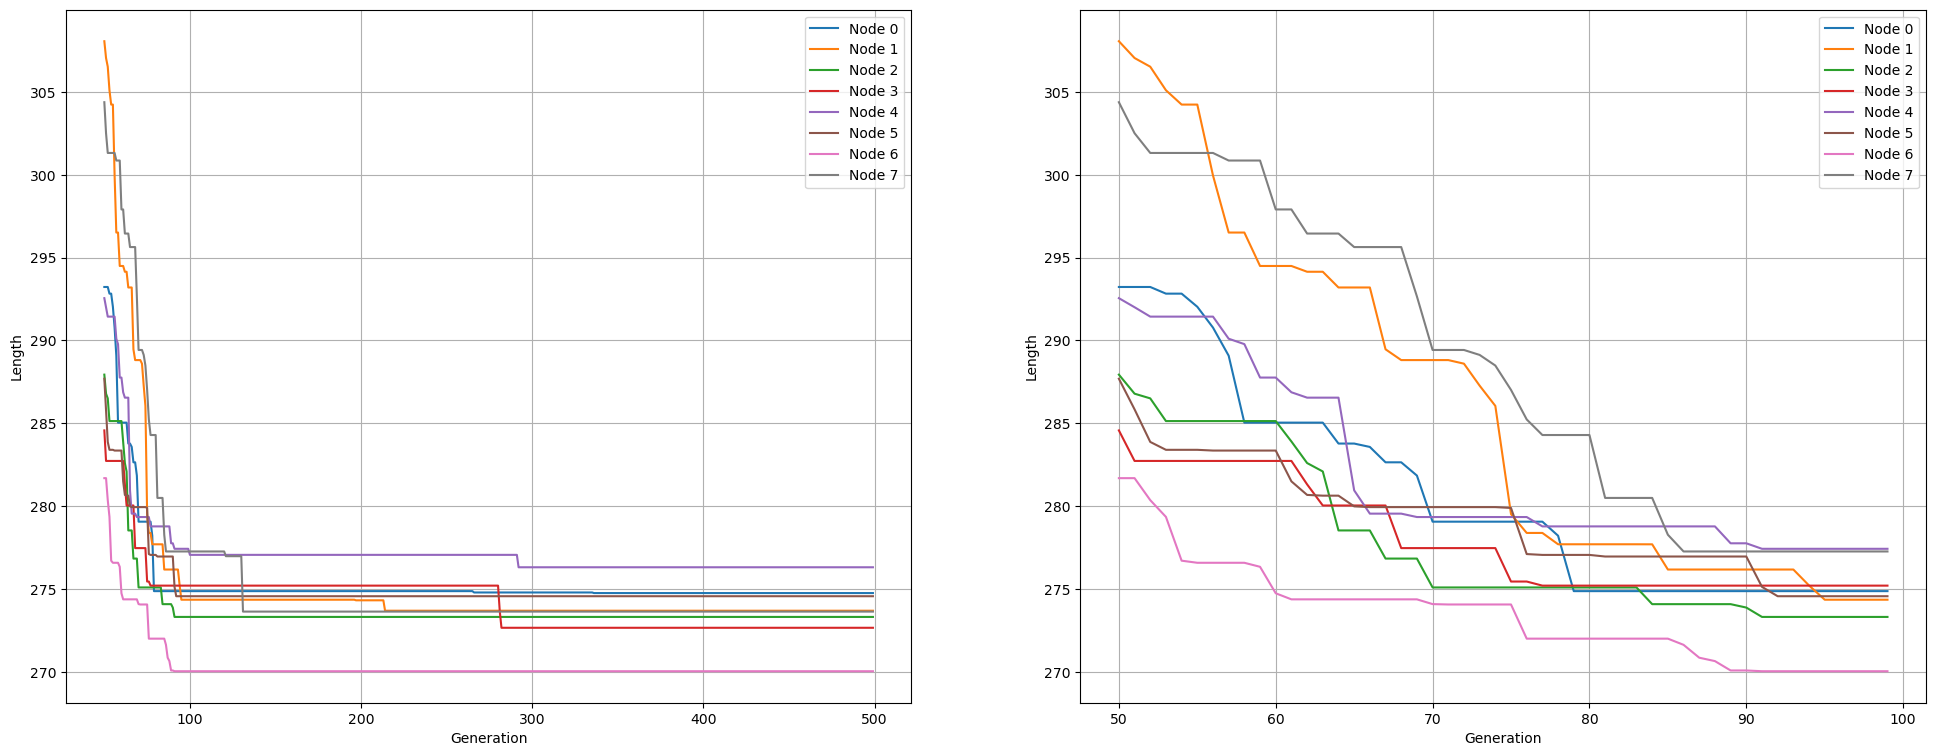

In [49]:
fig, plots = plt.subplots(1, 2, figsize=(24, 9))
besties = np.zeros(8)

for i in range(8):
    x, y1, y2 = np.loadtxt('Exercise10-1/CNC/best_individuals' + str(i) + '.txt', usecols=(0, 1, 2), unpack='true')
    best_length = y1[499]
    besties[i] = best_length
    plots[0].plot(x[50:500], y1[50:500], label='Node ' + str(i))
    plots[1].plot(x[50:100], y1[50:100], label='Node ' + str(i))
    print("Node", i, "Best Length:", best_length)

plots[0].legend()
plots[0].grid(True)
plots[0].set_title("")
plots[0].set_ylabel('Length')
plots[0].set_xlabel('Generation')

plots[1].legend()
plots[1].grid(True)
plots[1].set_title("")
plots[1].set_ylabel('Length')
plots[1].set_xlabel('Generation')

plt.show()

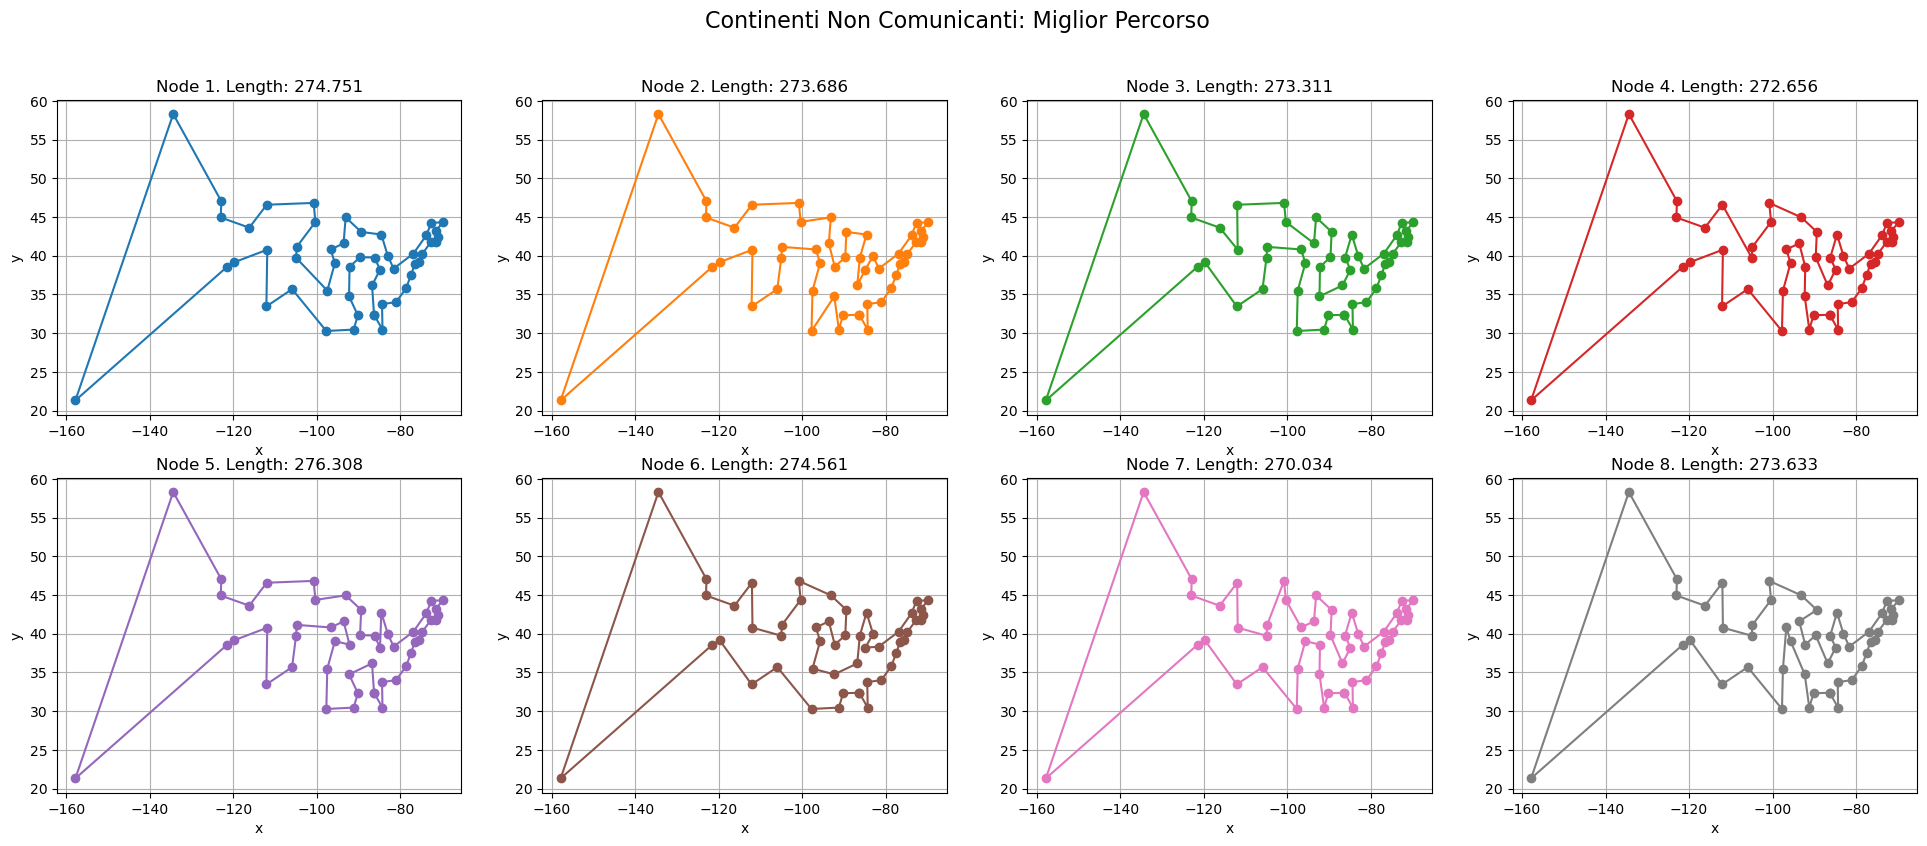

In [50]:
fig, axs = plt.subplots(2, 4, figsize=(24, 9))
fig.suptitle("Continenti Non Comunicanti: Miglior Percorso", size=16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
axs = axs.flatten()

for i, ax in enumerate(axs):
    node = i + 1
    x, y = np.loadtxt(f'Exercise10-1/CNC/path{i}.txt', usecols=(0, 1), unpack=True)
    ax.plot(x, y, marker='o', color=colors[i % len(colors)])  # Use a different color for each subplot
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Node {node}. Length: {besties[i]}')

plt.show()


I risultati dei primi due grafici mostrano che ogni nodo lavora in modo indipendente stabilizzandosi su un risultato differente. Infatti, come si vede negli otto grafici successivi, ogni nodo fornisce un risultato diverso, con alcuni nodi che operano in modo migliore di altri.

### Continenti Non Comunicanti
Infine, sono state aggiunte le migrazioni al codice, riducendo a $N_{migr}=50$ il numero del ciclo di anni dopo il quale si effettua una migrazione. La migrazione è stata implementata sotto forma di scambio dei primi $10$ individui migliori, prendendoli dalla testa dell'array di popolazione ordinato. 

Node 0 Best Length: 270.63
Node 1 Best Length: 270.63
Node 2 Best Length: 270.63
Node 3 Best Length: 270.63
Node 4 Best Length: 270.63
Node 5 Best Length: 270.63
Node 6 Best Length: 270.63
Node 7 Best Length: 270.63


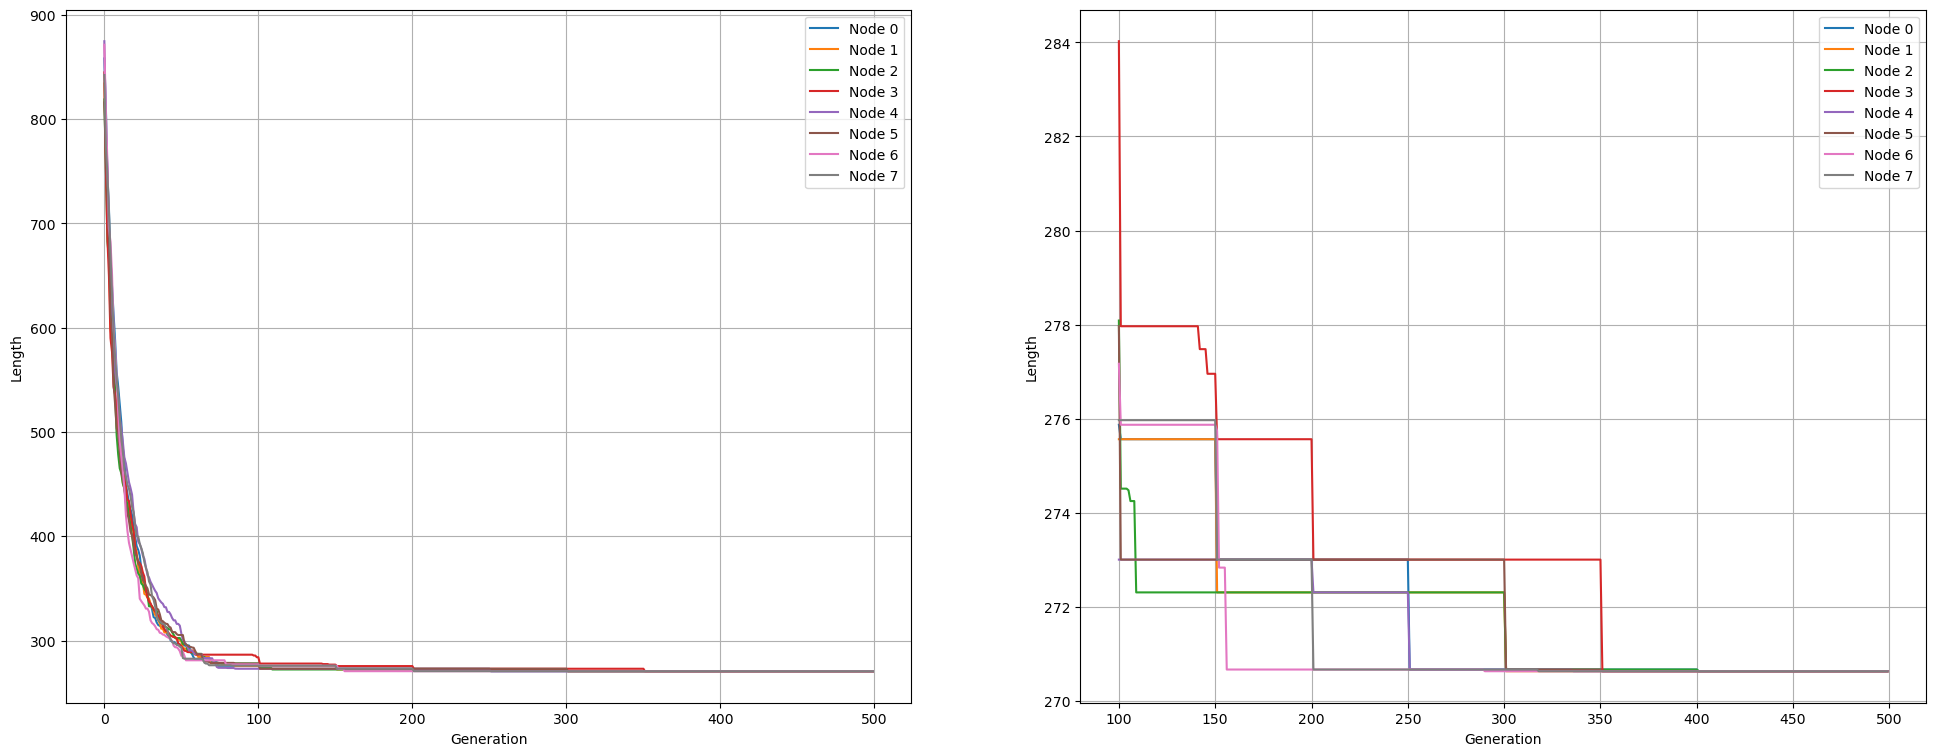

In [51]:
fig, plots = plt.subplots(1, 2, figsize=(24, 9))
besties = np.zeros(8)

for i in range(8):
    x, y1, y2 = np.loadtxt('Exercise10-1/CC/best_individuals' + str(i) + '.txt', usecols=(0, 1, 2), unpack='true')
    best_length = y1[499]
    besties[i] = best_length
    plots[0].plot(x, y1, label='Node ' + str(i))
    plots[1].plot(x[100:500], y1[100:500], label='Node ' + str(i))
    print("Node", i, "Best Length:", best_length)

plots[0].legend()
plots[0].grid(True)
plots[0].set_title("")
plots[0].set_ylabel('Length')
plots[0].set_xlabel('Generation')

plots[1].legend()
plots[1].grid(True)
plots[1].set_title("")
plots[1].set_ylabel('Length')
plots[1].set_xlabel('Generation')

plt.show()

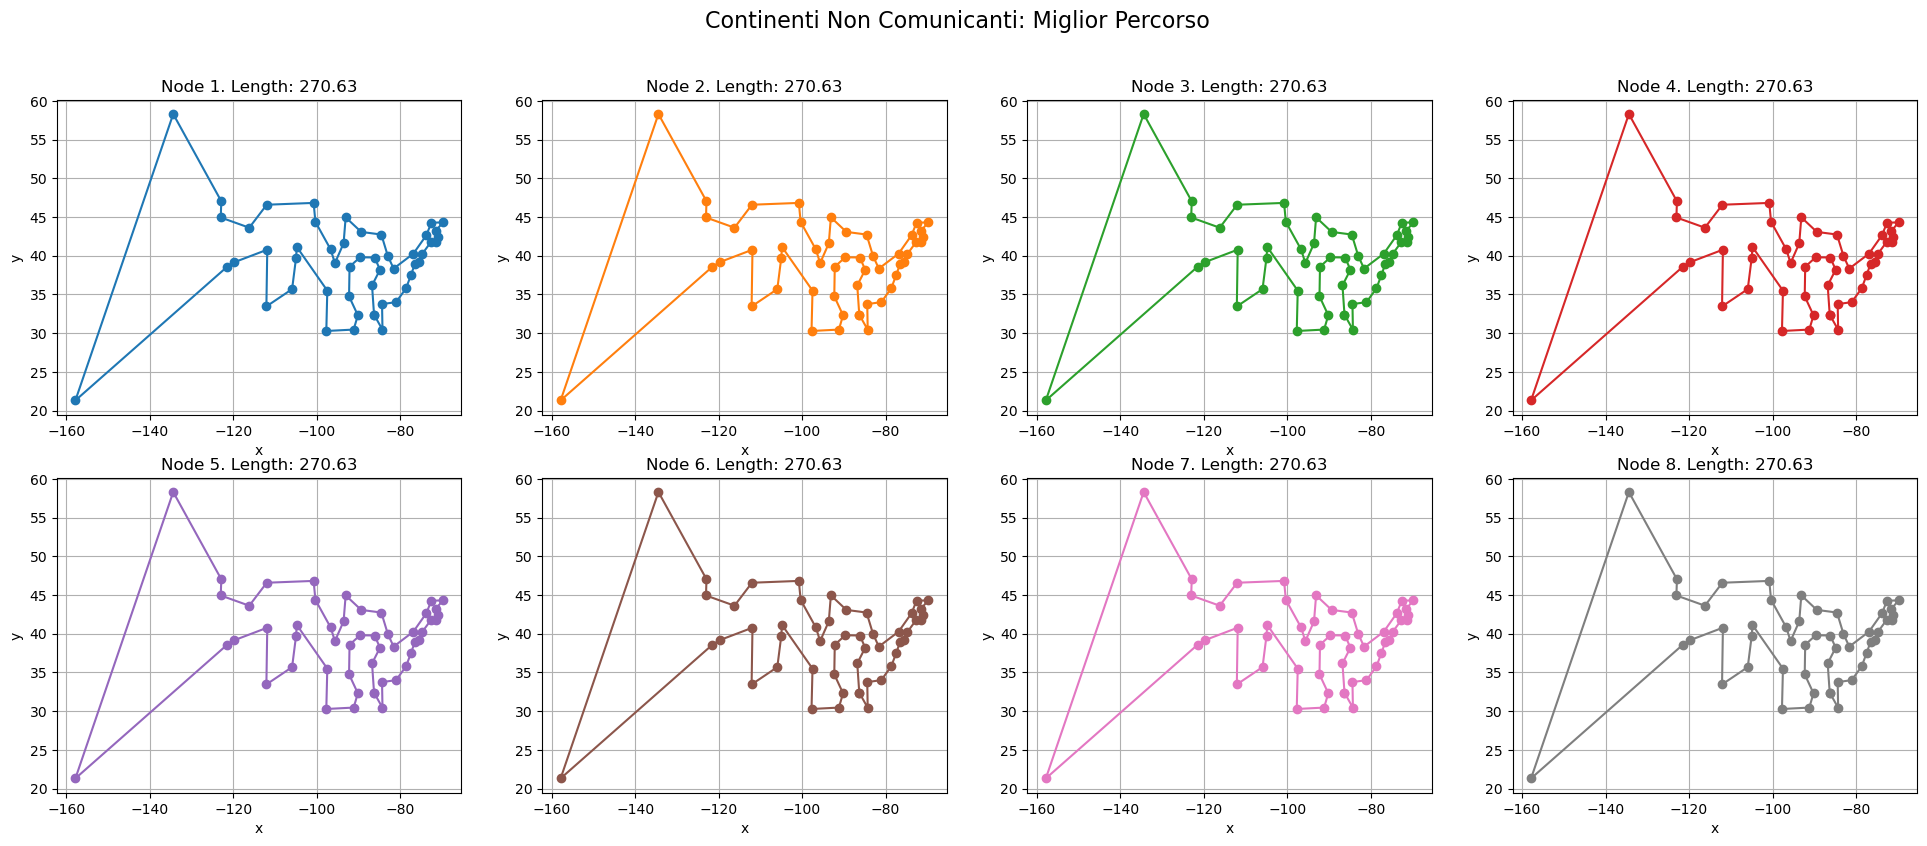

In [52]:
fig, axs = plt.subplots(2, 4, figsize=(24, 9))
fig.suptitle("Continenti Non Comunicanti: Miglior Percorso", size=16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
axs = axs.flatten()

for i, ax in enumerate(axs):
    node = i + 1
    x, y = np.loadtxt(f'Exercise10-1/CC/path{i}.txt', usecols=(0, 1), unpack=True)
    ax.plot(x, y, marker='o', color=colors[i % len(colors)])  # Use a different color for each subplot
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Node {node}. Length: {besties[i]}')

plt.show()


In questo caso, è interessante notare che la presenza delle migrazioni lega fortemente tra di loro l'operato dei nodi, facendo in modo che raggiungano tutti lo stesso minimo. Questo risultato è migliore rispetto a quello del caso di nodi non comunicanti. La ragione di questo giace nella dinamica delle migrazioni; se un nodo tende a trovare un minimo, come si è visto nel precedente caso, l'aggiunta di un altro individuo eventualmente migliore, proveniente da un altro continente, fornirà nuovo materiale genetico per il rimescolamento. Grazie a questo meccanismo, i miglioramenti presenti in un solo nodo riescono a beneficiare l'interezza dei processi. L'importanza delle migrazioni è visibile in maniera molto chiara nel grafico dell'errore. Infatti, nel caso di nodi non comunicanti, l'errore scende progressivamente, mentre nel caso di nodi comunicanti, si notano dei chiari gradini di abbassamento dell'errore proprio in corrispondenza delle generazioni nelle quali avviene la migrazione.